In [1]:
# load python packages
import earthpy as et
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np 
import os
import earthpy.spatial as es
# make plots plot inline
plt.ion()

# prettier plotting 
import seaborn as sns 
sns.set(font_scale=1.5)
sns.set_style("white")

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


## Open Raster Data  Using Context Manager

In [2]:
dtm_path = 'data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

with rio.open(dtm_path) as src:
    # reading the data into numpy as an array
    # set masked = true to import a masked array (no data values = masked)
    lidar_dtm_im = src.read(1, masked=True)
    # printing some metadata
    #print(src.bounds)
    # grab the spatial extent for plotting 
    spatial_extent = plotting_extent(src)
    metadata = src.meta
    
type(lidar_dtm_im)
lidar_dtm_im.shape
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS({'init': 'epsg:32613'}),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

## Plot The Data 

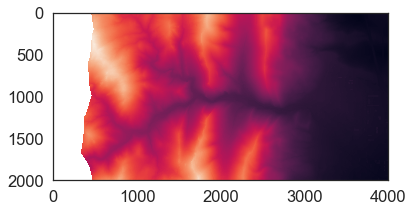

In [3]:
show(lidar_dtm_im)

In [4]:
lidar_dtm_im.shape

(2000, 4000)

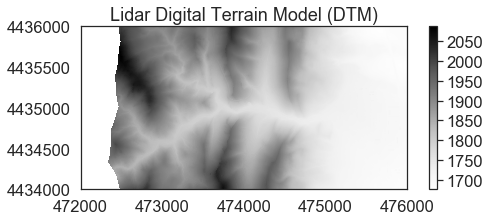

In [5]:
# plot using matplotlib
fig, ax = plt.subplots(figsize=(8,3))
# create a plot object for plotting
lidar_plot = ax.imshow(lidar_dtm_im, 
         cmap = "Greys",
         extent = spatial_extent);

ax.set_title("Lidar Digital Terrain Model (DTM)")
# use the plot object to create a colorbar
fig.colorbar(lidar_plot);

## Create a Histogram of Raster Data
frequency  -- of elevations values

In [6]:
lidar_dtm_im.ravel()

masked_array(data = [-- -- -- ..., 1681.8900146484375 1681.8099365234375 1681.739990234375],
             mask = [ True  True  True ..., False False False],
       fill_value = -3.40282e+38)

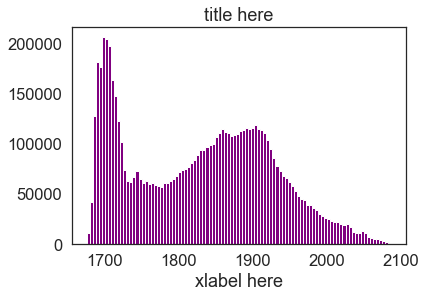

In [7]:
# plot histogram
fig, ax = plt.subplots()
ax.hist(lidar_dtm_im.ravel(),
       bins = 100, color='purple')
ax.set_title("title here")
ax.set_xlabel("xlabel here");

## Open Digital Surface Model from the Pre Flood Data

In [8]:
# Open up pre-flood DSM
dsm_path = "data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif"
with rio.open(dsm_path) as dsm_src:
    lidar_dsm_im = dsm_src.read(1, masked = True)
    spatial_extent_dsm = plotting_extent(dsm_src)
    
lidar_dsm_im.shape == lidar_dtm_im.shape
dsm_src.crs == src.crs

True

## Subtract the Rasters

In [9]:
# subtract
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
# view stats 
lidar_chm_im.max(), lidar_chm_im.min()

(26.930054, 0.0)

In [10]:
# the output calculated image is a masked array
lidar_chm_im

masked_array(data =
 [[-- -- -- ..., 0.0 0.1700439453125 0.9600830078125]
 [-- -- -- ..., 0.0 0.090087890625 1.6400146484375]
 [-- -- -- ..., 0.0 0.0 0.0799560546875]
 ..., 
 [-- -- -- ..., 0.0 0.0 0.0]
 [-- -- -- ..., 0.0 0.0 0.0]
 [-- -- -- ..., 0.0 0.0 0.0]],
             mask =
 [[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = -3.40282e+38)

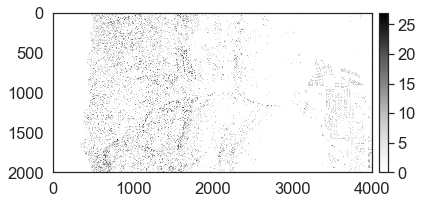

In [11]:
# the commented line below can be used if you want to interact with your raster (mouse over to view values)
# %matplotlib notebook

# plot the data - chm data 
fig, ax = plt.subplots()
lidar_chm_plot = ax.imshow(lidar_chm_im,
         cmap = "Greys")
es.colorbar(lidar_chm_plot);

## Classify The Canopy Height Model

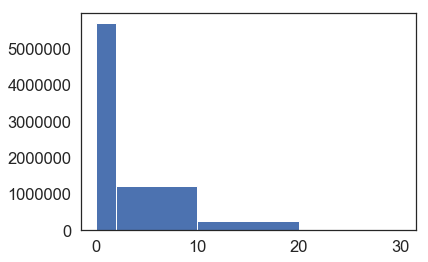

In [12]:
# plot a histogram of the data
fig, ax = plt.subplots()
ax.hist(lidar_chm_im.ravel(), bins=[0,2, 10, 20, 30]);

In [13]:
lidar_chm_im.min(), lidar_chm_im.max()
type(lidar_chm_im)

numpy.ma.core.MaskedArray

In [14]:
# classify the data using np.digitize()

# define the bins to use in classification
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.inf]
# classify your raster using numpy digitize
lidar_chm_im_class = np.digitize(lidar_chm_im, 
                                 class_bins)

np.unique(lidar_chm_im_class)

array([0, 1, 2, 3, 4])

In [15]:
# the 0's are actually your na or missing data values
lidar_chm_im_class

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

Below i use the `np.ma.masked_where()` function to assign all values in my array that -- 0 to a masked value. 

In [16]:
# you can turn your data into a masked array if you want
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 0, 
                              lidar_chm_im_class, 
                              copy=True)
# forcing two values to plot one line
lidar_chm_class_ma.min(), lidar_chm_class_ma.max()

(1, 4)

In [17]:
# now you have a masked array again which will plot nicely
type(lidar_chm_class_ma)

numpy.ma.core.MaskedArray

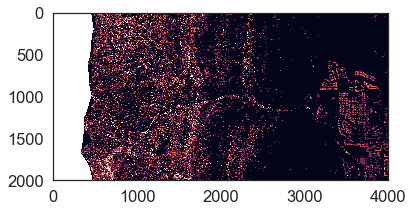

In [18]:
#%matplotlib notebook # uncomment this line if you want to interact with your plot
# plot the data!
fig, ax = plt.subplots()
ax.imshow(lidar_chm_class_ma);

you need to import a few more matplotlib functions for your legend to work
be sure to import these at the TOP of your notebook in your homework!! i'm just
adding them here so you see they need to be added but i'm commenting them out
as it's bad to add them here! !

In [19]:
#  add packages to the top of your notebook always not here!
#from matplotlib.patches import Patch
#from matplotlib.colors import ListedColormap, BoundaryNorm

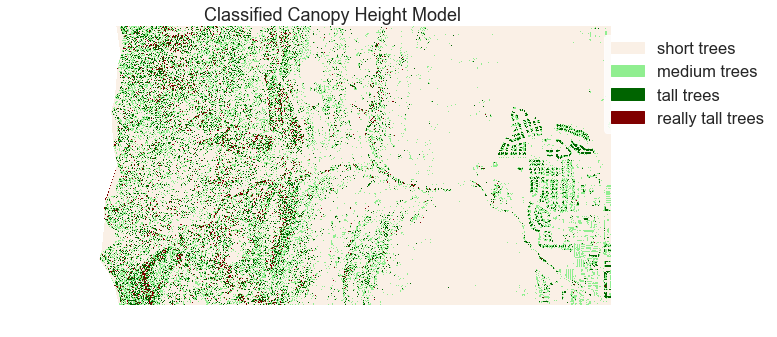

In [20]:

# plot data and add a nice legend!
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']

# create objects to use in the legend
# this includes the colored boxes and the appropriate labels
height_class_labels = ["short trees", "medium trees", "tall trees", "really tall trees"]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(colors, height_class_labels)]

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(lidar_chm_class_ma, 
          cmap=cmap)
ax.set_title("Classified Canopy Height Model")
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         bbox_to_anchor = (1.3,1)) # place legend to the RIGHT of the map
ax.set_axis_off();
